# Modeling - XGBoost per Classificazione IncidentGrade

**Obiettivo:** Predire il triage grade degli incidenti di cybersecurity (TruePositive, BenignPositive, FalsePositive)

**Modello:** XGBoost Classifier

**Metrica principale:** Macro F1-Score (come richiesto dal challenge GUIDE)

**Pipeline:**
1. Caricamento dati processati
2. Baseline model
3. Ottimizzazione iperparametri
4. Valutazione e analisi errori
5. Feature importance

## 1. Setup e Caricamento Dati

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


In [3]:
# Carica i dataset processati
print("Caricamento dataset processati...")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['IncidentGrade']
y_test = pd.read_csv('../data/processed/y_test.csv')['IncidentGrade']

print(f"\nX_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nDistribuzione y_train:")
print(y_train.value_counts())
print(f"\nProporzioni:")
print(y_train.value_counts(normalize=True))

Caricamento dataset processati...

X_train: (359120, 23)
X_test: (89781, 23)
y_train: (359120,)
y_test: (89781,)

Distribuzione y_train:
IncidentGrade
BenignPositive    174504
FalsePositive     108126
TruePositive       76490
Name: count, dtype: int64

Proporzioni:
IncidentGrade
BenignPositive    0.485921
FalsePositive     0.301086
TruePositive      0.212993
Name: proportion, dtype: float64


In [4]:
# Converti label in numeri per XGBoost
from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("Mapping label:")
for i, label in enumerate(le_target.classes_):
    print(f"  {label} -> {i}")

Mapping label:
  BenignPositive -> 0
  FalsePositive -> 1
  TruePositive -> 2


## 2. Baseline Model

In [5]:
print("Training baseline XGBoost model...\n")

# Baseline XGBoost con parametri di default
baseline_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target.classes_),
    eval_metric='mlogloss',
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# Training
baseline_model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    verbose=True
)

print("Training completato!")

Training baseline XGBoost model...

[0]	validation_0-mlogloss:0.91658
[1]	validation_0-mlogloss:0.81931
[2]	validation_0-mlogloss:0.74483
[3]	validation_0-mlogloss:0.69628
[4]	validation_0-mlogloss:0.65760
[5]	validation_0-mlogloss:0.62752
[6]	validation_0-mlogloss:0.60429
[7]	validation_0-mlogloss:0.58817
[8]	validation_0-mlogloss:0.56992
[9]	validation_0-mlogloss:0.55270
[10]	validation_0-mlogloss:0.54360
[11]	validation_0-mlogloss:0.53014
[12]	validation_0-mlogloss:0.51846
[13]	validation_0-mlogloss:0.50996
[14]	validation_0-mlogloss:0.49808
[15]	validation_0-mlogloss:0.49025
[16]	validation_0-mlogloss:0.48321
[17]	validation_0-mlogloss:0.47456
[18]	validation_0-mlogloss:0.46598
[19]	validation_0-mlogloss:0.45612
[20]	validation_0-mlogloss:0.45168
[21]	validation_0-mlogloss:0.44672
[22]	validation_0-mlogloss:0.44169
[23]	validation_0-mlogloss:0.43656
[24]	validation_0-mlogloss:0.43174
[25]	validation_0-mlogloss:0.42603
[26]	validation_0-mlogloss:0.42098
[27]	validation_0-mlogloss:0.

In [6]:
# Predizioni baseline
y_pred_baseline = baseline_model.predict(X_test)

# Metriche
print("=" * 70)
print("BASELINE MODEL - PERFORMANCE")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test_encoded, 
    y_pred_baseline, 
    target_names=le_target.classes_,
    digits=4
))

# Metriche aggregate
accuracy = accuracy_score(y_test_encoded, y_pred_baseline)
macro_f1 = f1_score(y_test_encoded, y_pred_baseline, average='macro')
macro_precision = precision_score(y_test_encoded, y_pred_baseline, average='macro')
macro_recall = recall_score(y_test_encoded, y_pred_baseline, average='macro')

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"MACRO F1-SCORE:    {macro_f1:.4f}")
print(f"MACRO PRECISION:   {macro_precision:.4f}")
print(f"MACRO RECALL:      {macro_recall:.4f}")

BASELINE MODEL - PERFORMANCE

Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.8666    0.9323    0.8982     43627
 FalsePositive     0.8786    0.8510    0.8646     27032
  TruePositive     0.8642    0.7531    0.8048     19122

      accuracy                         0.8696     89781
     macro avg     0.8698    0.8455    0.8559     89781
  weighted avg     0.8697    0.8696    0.8682     89781


ACCURACY:          0.8696
MACRO F1-SCORE:    0.8559
MACRO PRECISION:   0.8698
MACRO RECALL:      0.8455


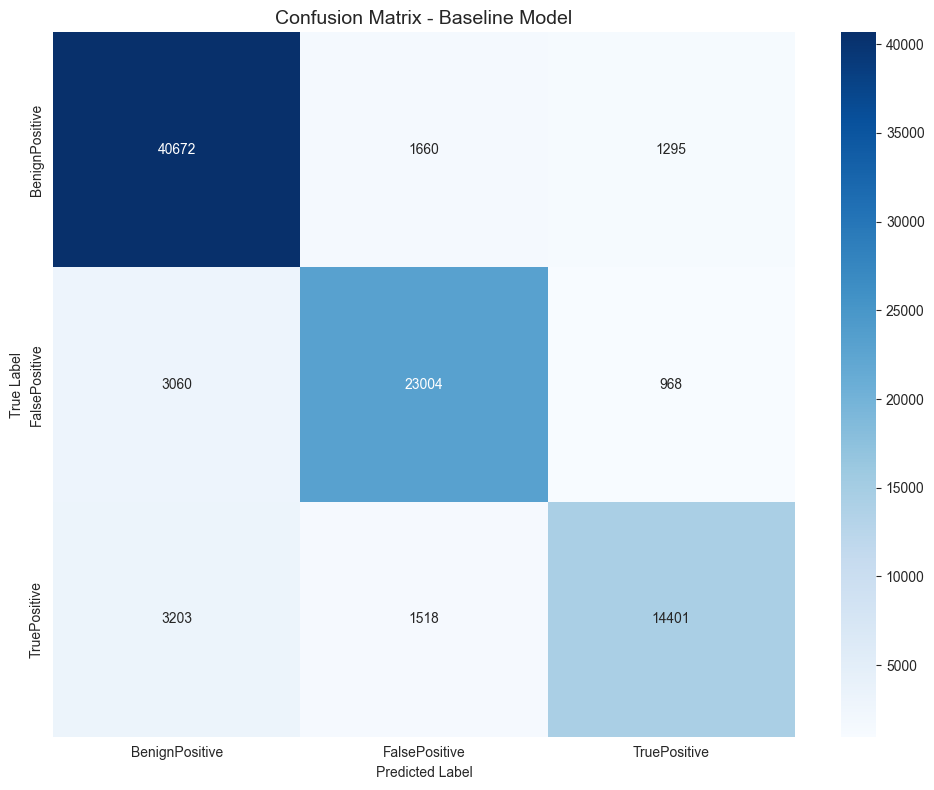

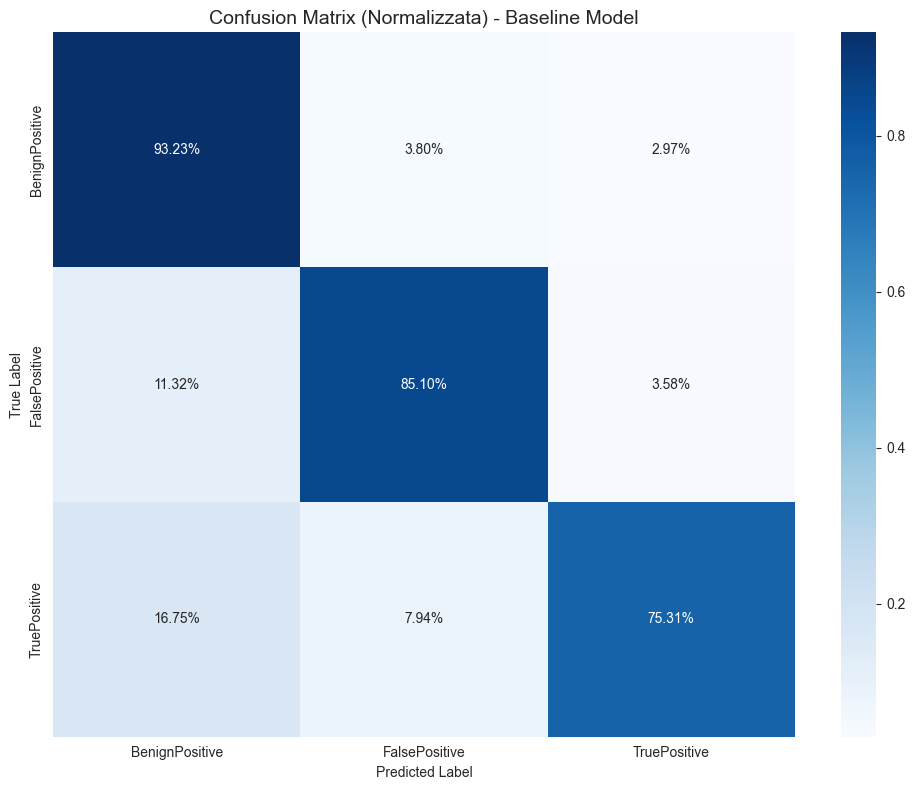

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred_baseline)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Confusion Matrix - Baseline Model', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Confusion matrix normalizzata
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_)
plt.title('Confusion Matrix (Normalizzata) - Baseline Model', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 3. Ottimizzazione Iperparametri

In [8]:
# Calcola class weights per gestire lo sbilanciamento
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_encoded
)

print("Sample weights calcolati per bilanciamento classi")

Sample weights calcolati per bilanciamento classi


In [9]:
print("Training modello ottimizzato...\n")

# XGBoost con parametri ottimizzati
optimized_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target.classes_),
    eval_metric='mlogloss',
    
    # Parametri ottimizzati
    max_depth=8,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    
    # Altro
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

# Training con sample weights
optimized_model.fit(
    X_train, y_train_encoded,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test_encoded)],
    verbose=False
)

print("Training completato!")

Training modello ottimizzato...

Training completato!


In [10]:
# Predizioni modello ottimizzato
y_pred_optimized = optimized_model.predict(X_test)

# Metriche
print("=" * 70)
print("OPTIMIZED MODEL - PERFORMANCE")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test_encoded, 
    y_pred_optimized, 
    target_names=le_target.classes_,
    digits=4
))

# Metriche aggregate
accuracy_opt = accuracy_score(y_test_encoded, y_pred_optimized)
macro_f1_opt = f1_score(y_test_encoded, y_pred_optimized, average='macro')
macro_precision_opt = precision_score(y_test_encoded, y_pred_optimized, average='macro')
macro_recall_opt = recall_score(y_test_encoded, y_pred_optimized, average='macro')

print(f"\nACCURACY:          {accuracy_opt:.4f}")
print(f"MACRO F1-SCORE:    {macro_f1_opt:.4f}")
print(f"MACRO PRECISION:   {macro_precision_opt:.4f}")
print(f"MACRO RECALL:      {macro_recall_opt:.4f}")

OPTIMIZED MODEL - PERFORMANCE

Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.9317    0.8592    0.8940     43627
 FalsePositive     0.8588    0.8710    0.8648     27032
  TruePositive     0.7444    0.8617    0.7988     19122

      accuracy                         0.8633     89781
     macro avg     0.8450    0.8640    0.8525     89781
  weighted avg     0.8699    0.8633    0.8649     89781


ACCURACY:          0.8633
MACRO F1-SCORE:    0.8525
MACRO PRECISION:   0.8450
MACRO RECALL:      0.8640


In [11]:
# Confronto baseline vs ottimizzato
comparison = pd.DataFrame({
    'Metrica': ['Accuracy', 'Macro F1', 'Macro Precision', 'Macro Recall'],
    'Baseline': [accuracy, macro_f1, macro_precision, macro_recall],
    'Ottimizzato': [accuracy_opt, macro_f1_opt, macro_precision_opt, macro_recall_opt]
})
comparison['Miglioramento'] = ((comparison['Ottimizzato'] - comparison['Baseline']) / comparison['Baseline'] * 100).round(2)

print("\n" + "=" * 70)
print("CONFRONTO BASELINE vs OTTIMIZZATO")
print("=" * 70)
print(comparison.to_string(index=False))


CONFRONTO BASELINE vs OTTIMIZZATO
        Metrica  Baseline  Ottimizzato  Miglioramento
       Accuracy  0.869638     0.863267          -0.73
       Macro F1  0.855879     0.852528          -0.39
Macro Precision  0.869792     0.844968          -2.85
   Macro Recall  0.845457     0.863956           2.19


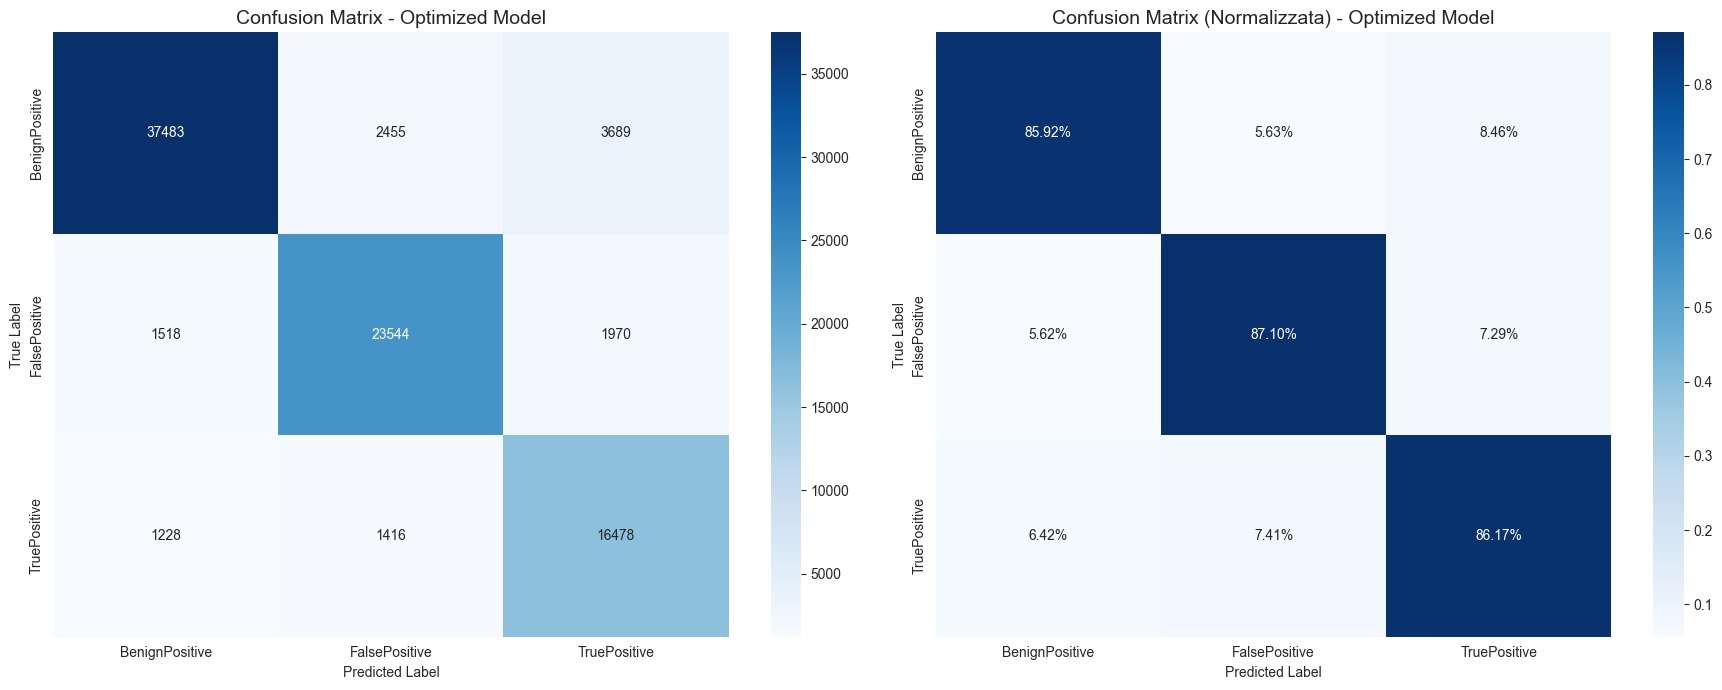

In [12]:
# Confusion Matrix modello ottimizzato
cm_opt = confusion_matrix(y_test_encoded, y_pred_optimized)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Confusion matrix assoluta
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0])
axes[0].set_title('Confusion Matrix - Optimized Model', fontsize=14)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion matrix normalizzata
cm_opt_norm = cm_opt.astype('float') / cm_opt.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_opt_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalizzata) - Optimized Model', fontsize=14)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## 4. Cross-Validation

In [13]:
print("Esecuzione 5-Fold Stratified Cross-Validation...\n")

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation con macro F1
cv_scores = cross_val_score(
    optimized_model, 
    X_train, y_train_encoded,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"Cross-Validation Macro F1 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia:  {cv_scores.mean():.4f}")
print(f"Std:    {cv_scores.std():.4f}")
print(f"Min:    {cv_scores.min():.4f}")
print(f"Max:    {cv_scores.max():.4f}")

Esecuzione 5-Fold Stratified Cross-Validation...

Cross-Validation Macro F1 Scores:
  Fold 1: 0.8563
  Fold 2: 0.8589
  Fold 3: 0.8573
  Fold 4: 0.8571
  Fold 5: 0.8556

Media:  0.8570
Std:    0.0011
Min:    0.8556
Max:    0.8589


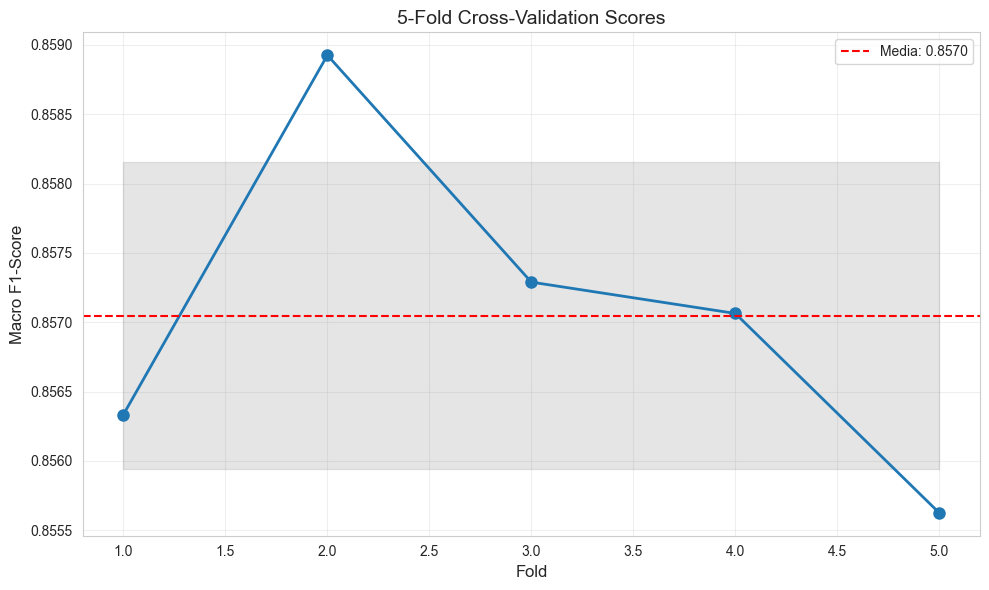

In [14]:
# Visualizza CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Media: {cv_scores.mean():.4f}')
plt.fill_between(range(1, len(cv_scores) + 1), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='gray')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Macro F1-Score', fontsize=12)
plt.title('5-Fold Cross-Validation Scores', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Importance

In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': optimized_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Features più importanti:
            Feature  Importance
        OrgId_first    0.244606
DetectorId_get_mode    0.147677
   NumWithSuspicion    0.092031
          NumAlerts    0.084854
     NumWithVerdict    0.073666
       NumEvidences    0.069554
  Category_get_mode    0.064355
       NumWithMitre    0.047149
     NumUniqueMitre    0.027779
     NumEntityTypes    0.022834
   Duration_seconds    0.020791
      IsWeekend_max    0.014579
          Hour_Last    0.011942
 DayOfWeek_get_mode    0.011270
       NumCountries    0.010085
   NumEvidenceRoles    0.008926
          NumCities    0.008138
           Hour_Avg    0.007635
         Hour_First    0.007175
          NumStates    0.006685


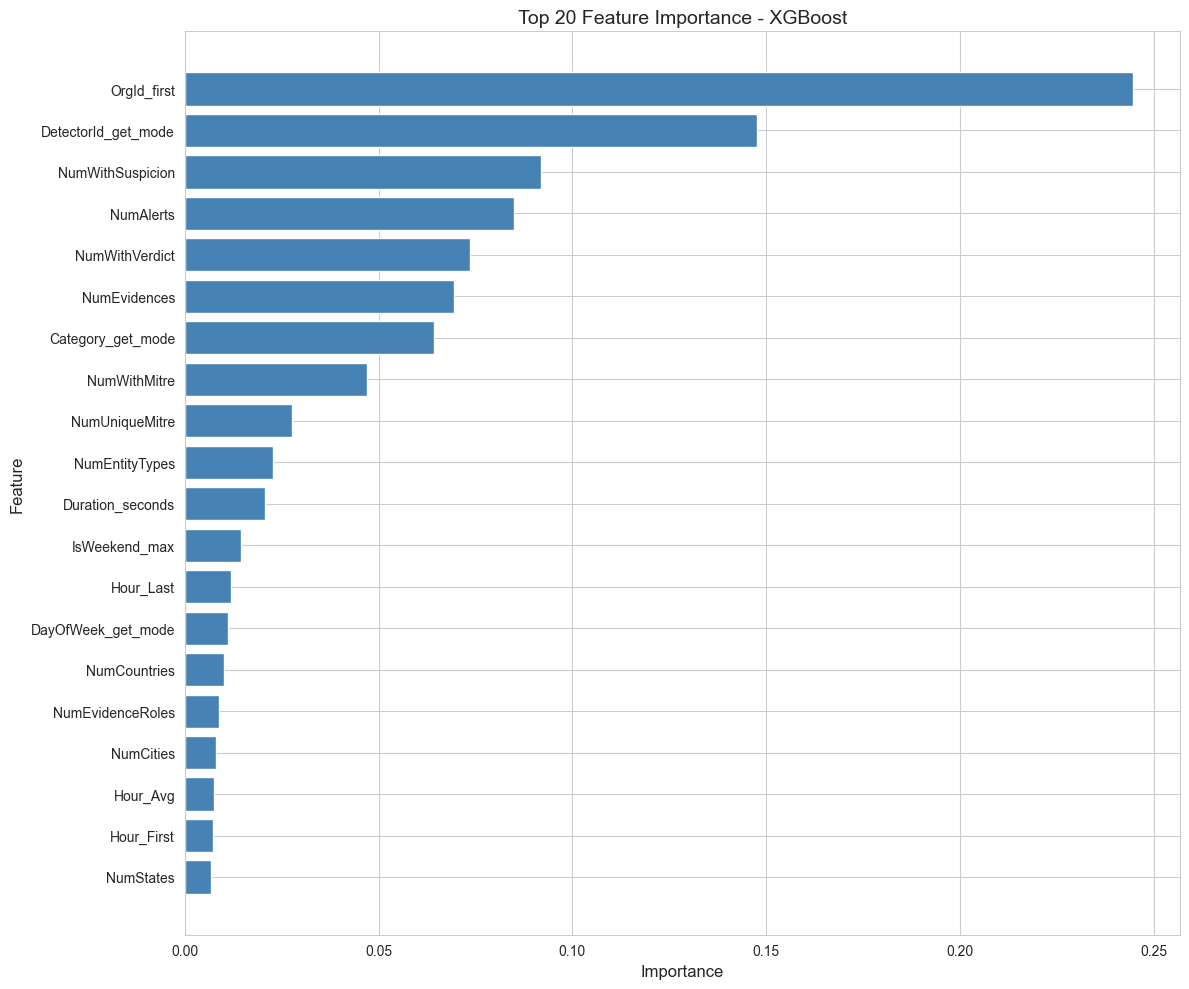

In [16]:
# Plot feature importance
plt.figure(figsize=(12, 10))
top_n = 20
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='steelblue')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - XGBoost', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

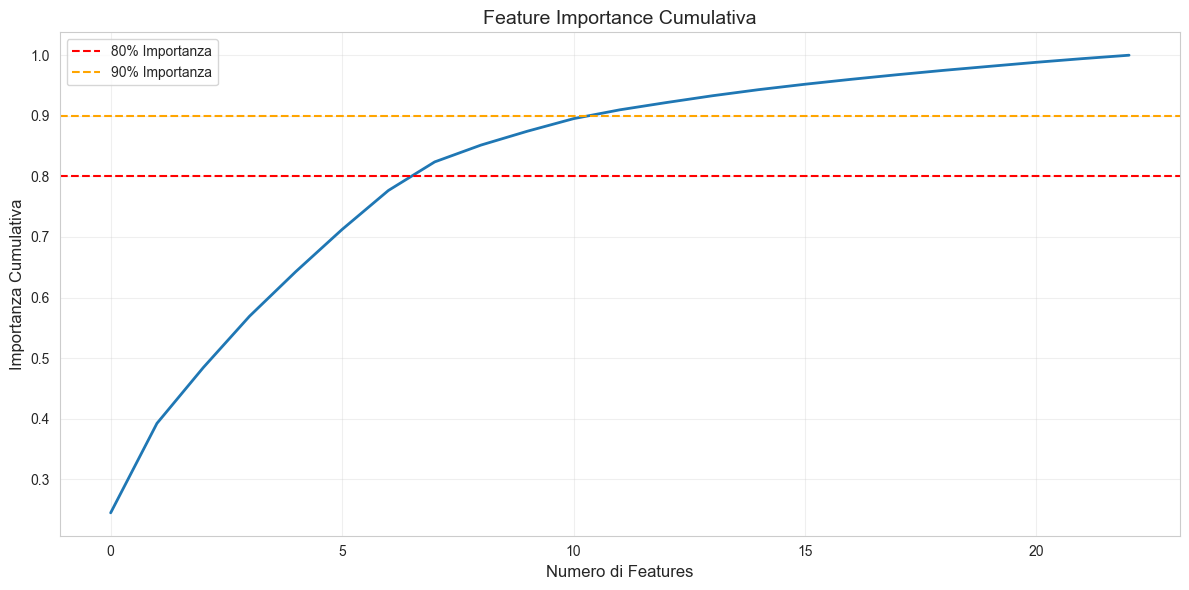


Features necessarie per:
  80% importanza: 7/23
  90% importanza: 11/23


In [17]:
# Feature importance cumulativa
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum() / feature_importance['Importance'].sum()

plt.figure(figsize=(12, 6))
plt.plot(range(len(feature_importance)), feature_importance['Cumulative_Importance'], linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Importanza')
plt.axhline(y=0.9, color='orange', linestyle='--', label='90% Importanza')
plt.xlabel('Numero di Features', fontsize=12)
plt.ylabel('Importanza Cumulativa', fontsize=12)
plt.title('Feature Importance Cumulativa', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Quante features servono per 80% e 90%?
n_features_80 = (feature_importance['Cumulative_Importance'] <= 0.8).sum()
n_features_90 = (feature_importance['Cumulative_Importance'] <= 0.9).sum()

print(f"\nFeatures necessarie per:")
print(f"  80% importanza: {n_features_80}/{len(feature_importance)}")
print(f"  90% importanza: {n_features_90}/{len(feature_importance)}")

## 6. Analisi Errori

In [18]:
# Identifica predizioni errate
errors_mask = y_test_encoded != y_pred_optimized
n_errors = errors_mask.sum()

print(f"Numero di errori: {n_errors} su {len(y_test_encoded)} ({n_errors/len(y_test_encoded)*100:.2f}%)")

# Analizza tipo di errori
error_analysis = pd.DataFrame({
    'True': le_target.inverse_transform(y_test_encoded[errors_mask]),
    'Predicted': le_target.inverse_transform(y_pred_optimized[errors_mask])
})

print("\nTipi di errori più comuni:")
error_counts = error_analysis.groupby(['True', 'Predicted']).size().sort_values(ascending=False)
print(error_counts.head(10))

Numero di errori: 12276 su 89781 (13.67%)

Tipi di errori più comuni:
True            Predicted     
BenignPositive  TruePositive      3689
                FalsePositive     2455
FalsePositive   TruePositive      1970
                BenignPositive    1518
TruePositive    FalsePositive     1416
                BenignPositive    1228
dtype: int64


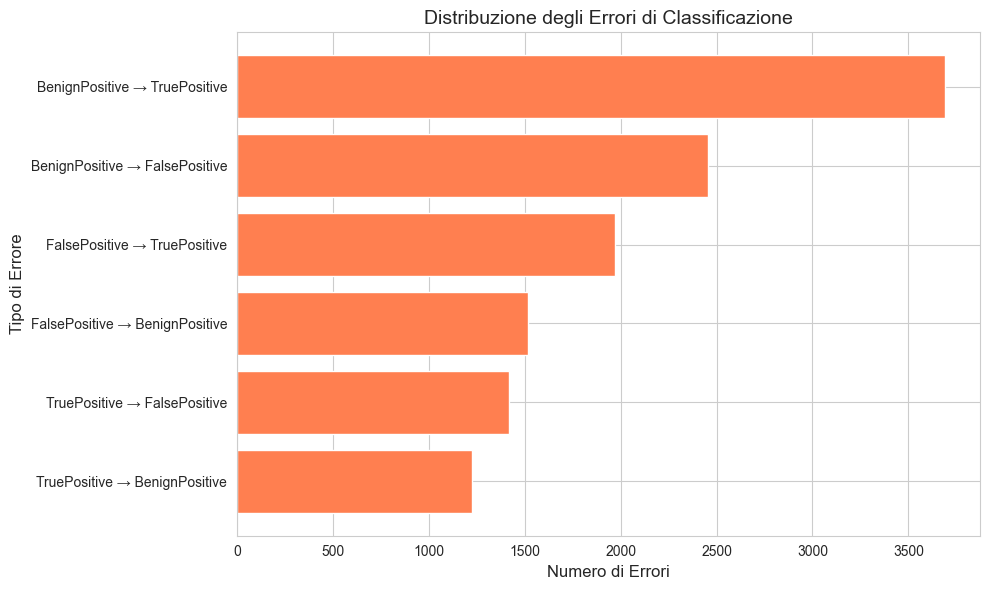

In [19]:
# Visualizza distribuzione errori
plt.figure(figsize=(10, 6))
error_counts_df = error_counts.reset_index()
error_counts_df.columns = ['True', 'Predicted', 'Count']
error_counts_df['Error_Type'] = error_counts_df['True'] + ' → ' + error_counts_df['Predicted']

plt.barh(range(len(error_counts_df)), error_counts_df['Count'], color='coral')
plt.yticks(range(len(error_counts_df)), error_counts_df['Error_Type'])
plt.xlabel('Numero di Errori', fontsize=12)
plt.ylabel('Tipo di Errore', fontsize=12)
plt.title('Distribuzione degli Errori di Classificazione', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Predizioni con Probabilità

In [20]:
# Ottieni probabilità per analisi più approfondita
y_pred_proba = optimized_model.predict_proba(X_test)

# Analizza confidence delle predizioni
max_proba = y_pred_proba.max(axis=1)

print("Distribuzione confidence delle predizioni:")
print(f"  Media:    {max_proba.mean():.4f}")
print(f"  Mediana:  {np.median(max_proba):.4f}")
print(f"  Min:      {max_proba.min():.4f}")
print(f"  Max:      {max_proba.max():.4f}")

# Distribuzione per correttezza predizione
correct_mask = y_test_encoded == y_pred_optimized
print(f"\nConfidence predizioni corrette: {max_proba[correct_mask].mean():.4f}")
print(f"Confidence predizioni errate:   {max_proba[~correct_mask].mean():.4f}")

Distribuzione confidence delle predizioni:
  Media:    0.8165
  Mediana:  0.9146
  Min:      0.3340
  Max:      0.9994

Confidence predizioni corrette: 0.8582
Confidence predizioni errate:   0.5535


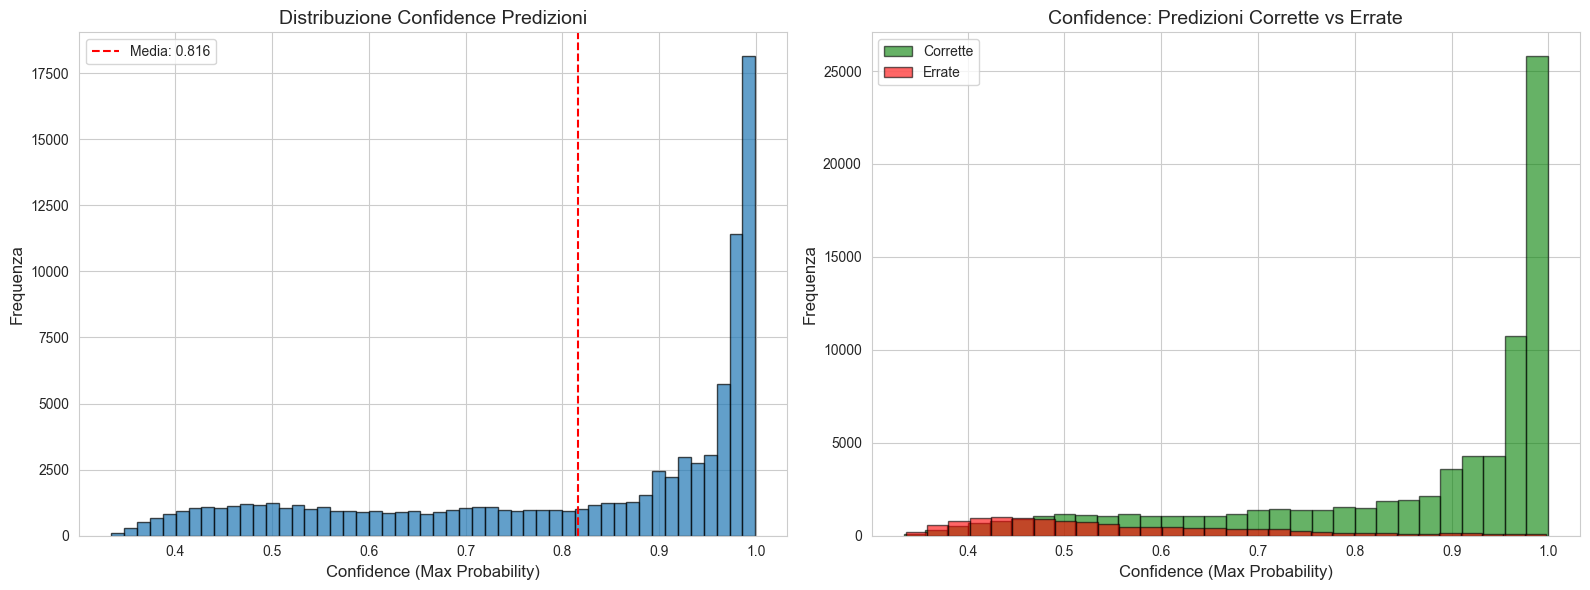

In [22]:
# Visualizza distribuzione confidence
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram generale
axes[0].hist(max_proba, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(max_proba.mean(), color='r', linestyle='--', label=f'Media: {max_proba.mean():.3f}')
axes[0].set_xlabel('Confidence (Max Probability)', fontsize=12)
axes[0].set_ylabel('Frequenza', fontsize=12)
axes[0].set_title('Distribuzione Confidence Predizioni', fontsize=14)
axes[0].legend()

# Comparison corrette vs errate
axes[1].hist(max_proba[correct_mask], bins=30, alpha=0.6, label='Corrette', color='green', edgecolor='black')
axes[1].hist(max_proba[~correct_mask], bins=30, alpha=0.6, label='Errate', color='red', edgecolor='black')
axes[1].set_xlabel('Confidence (Max Probability)', fontsize=12)
axes[1].set_ylabel('Frequenza', fontsize=12)
axes[1].set_title('Confidence: Predizioni Corrette vs Errate', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Salvataggio Modello

In [23]:
# Salva il modello ottimizzato
import os
os.makedirs('../models', exist_ok=True)

# Salva modello XGBoost
optimized_model.save_model('../models/xgboost_optimized.json')

# Salva anche con pickle per compatibilità
with open('../models/xgboost_optimized.pkl', 'wb') as f:
    pickle.dump(optimized_model, f)

# Salva label encoder
with open('../models/label_encoder_target.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Salva feature importance
feature_importance.to_csv('../models/feature_importance.csv', index=False)

print("Modello e artifacts salvati in ../models/")
print("  - xgboost_optimized.json")
print("  - xgboost_optimized.pkl")
print("  - label_encoder_target.pkl")
print("  - feature_importance.csv")

Modello e artifacts salvati in ../models/
  - xgboost_optimized.json
  - xgboost_optimized.pkl
  - label_encoder_target.pkl
  - feature_importance.csv


## 9. Riepilogo Finale

In [28]:
print("=" * 70)
print("RIEPILOGO FINALE - XGBOOST CLASSIFIER")
print("=" * 70)

print(f"\nDATASET:")
print(f"  Training samples:  {len(X_train):,}")
print(f"  Test samples:      {len(X_test):,}")
print(f"  Features:          {X_train.shape[1]}")
print(f"  Classi:            {len(le_target.classes_)} ({', '.join(le_target.classes_)})")

print(f"\nPERFORMANCE TEST SET:")
print(f"  Accuracy:          {accuracy_opt:.4f}")
print(f"  Macro F1-Score:    {macro_f1_opt:.4f} ⭐")
print(f"  Macro Precision:   {macro_precision_opt:.4f}")
print(f"  Macro Recall:      {macro_recall_opt:.4f}")

print(f"\nCROSS-VALIDATION (5-Fold):")
print(f"  Macro F1 medio:    {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\nTOP 5 FEATURES:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['Feature']:30s} {row['Importance']:.4f}")

print(f"\nPERFORMANCE PER CLASSE:")
for i, label in enumerate(le_target.classes_):
    mask = y_test_encoded == i
    class_f1 = f1_score(y_test_encoded[mask], y_pred_optimized[mask], average='macro', zero_division=0)
    class_acc = accuracy_score(y_test_encoded[mask], y_pred_optimized[mask])
    print(f"  {label:20s} F1: {class_f1:.4f}  Accuracy: {class_acc:.4f}")

print("\n" + "=" * 70)

RIEPILOGO FINALE - XGBOOST CLASSIFIER

DATASET:
  Training samples:  359,120
  Test samples:      89,781
  Features:          23
  Classi:            3 (BenignPositive, FalsePositive, TruePositive)

PERFORMANCE TEST SET:
  Accuracy:          0.8633
  Macro F1-Score:    0.8525 ⭐
  Macro Precision:   0.8450
  Macro Recall:      0.8640

CROSS-VALIDATION (5-Fold):
  Macro F1 medio:    0.8570 ± 0.0011

TOP 5 FEATURES:
  OrgId_first                    0.2446
  DetectorId_get_mode            0.1477
  NumWithSuspicion               0.0920
  NumAlerts                      0.0849
  NumWithVerdict                 0.0737

PERFORMANCE PER CLASSE:
  BenignPositive       F1: 0.3081  Accuracy: 0.8592
  FalsePositive        F1: 0.3103  Accuracy: 0.8710
  TruePositive         F1: 0.3086  Accuracy: 0.8617



## 10. Prossimi Passi

**Possibili miglioramenti:**

1. **Grid Search/Random Search:** Ottimizzazione sistematica iperparametri
2. **Ensemble Methods:** Combinare XGBoost con LightGBM, CatBoost, Random Forest
3. **Feature Engineering avanzato:** 
   - Interazioni tra features
   - Aggregazioni temporali più sofisticate
   - Features da testo (MITRE Techniques)
4. **Gestione sbilanciamento:** SMOTE, ADASYN per oversampling
5. **Threshold tuning:** Ottimizzare soglie di classificazione per massimizzare F1
6. **Analisi errori:** Studio approfondito dei casi difficili
7. **Calibrazione probabilità:** Platt scaling o isotonic regression

**Per production:**
- Pipeline completa con preprocessing
- Monitoring delle performance nel tempo
- A/B testing vs baseline
- Explainability con SHAP values